# Contents

- Introduction
- Oscillators
    - Sine Wave
    - Square Wave
    - Sawtooth Wave
    - Triangle Wave
    - Harmonic Analysis
    - Additive Synthesis
- Modulation
    - ADSR Envelope
    - LFO (Low-Frequency Oscillator)
- Effects
    - Low-Pass e High-Pass Filters

---

# Introduction

A synthesizer is an electric instrument that can be [analog](https://en.wikipedia.org/wiki/Moog_synthesizer) or [digital](https://en.wikipedia.org/wiki/NI_Massive). Synths can be quite complex, but they can be simplified in three main components:
- **Oscillators**: they generate the raw sound waveforms (e.g. sine waves)
- **Modulators**: they shape the sound over time, modifying amplitude or pitch (e.g. ADSR)
- **Effects**: they process the sound after it is generated (e.g. filters, delay, etc.)

In [41]:
import itertools
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, lfilter_zi, tf2zpk, spectrogram
from scipy.io import wavfile
from IPython.display import Audio

def samples_to_wav(samples, name="file.wav", amp=0.05, sample_rate=44_100):
    folder = 'audio/'
    
    data = np.array(samples)
    data = np.clip(data, -1, 1)
    data = np.int16(amp * data * (2**15 - 1))
    wavfile.write(folder + name, sample_rate, data)
    return display(Audio(folder + name))
    

In [42]:
SAMPLE_RATE = 44_100

# Oscillators

In this section I will start by showing the four most common oscillators found in any synths. Starting from a basic sine wave and then, by modifying it, getting to more complex waveforms such as square, sawtooth and triangle waves. Each of these waves has its own harmonics that I will show and compare to the others. At the end of the section I will show an example of additive synthesis i.e. how to generate more rich sounds by adding basic waves together. This is one of the two main ways synthesizers work, the other being subtractive synthesis, where sound is shaped by filtering certain frequencies of an harmonically rich waveform.

## Sine Wave

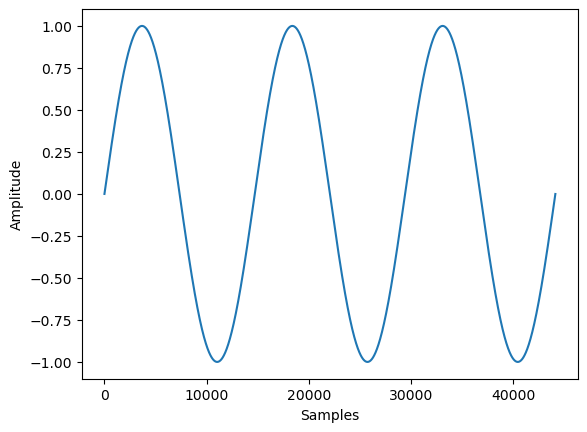

In [43]:
from synth.oscillators.sine_oscillator import SineOscillator

y = list(itertools.islice(SineOscillator(freq=3), SAMPLE_RATE))
x = np.arange(SAMPLE_RATE)

plt.plot(x, y)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Square Wave

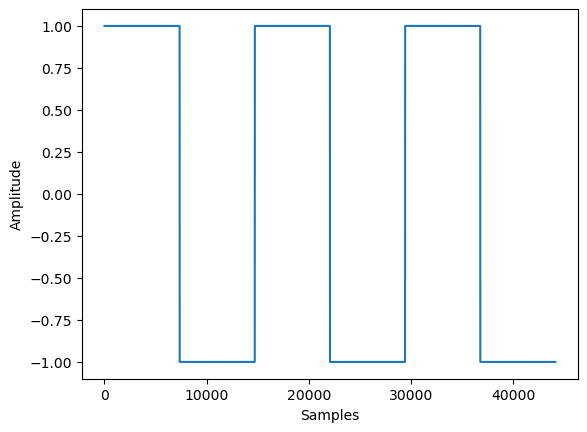

In [44]:
from synth.oscillators.square_oscillator import SquareOscillator

y = list(itertools.islice(SquareOscillator(freq=3), SAMPLE_RATE))
x = np.arange(SAMPLE_RATE)

plt.plot(x, y)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Sawtooth wave

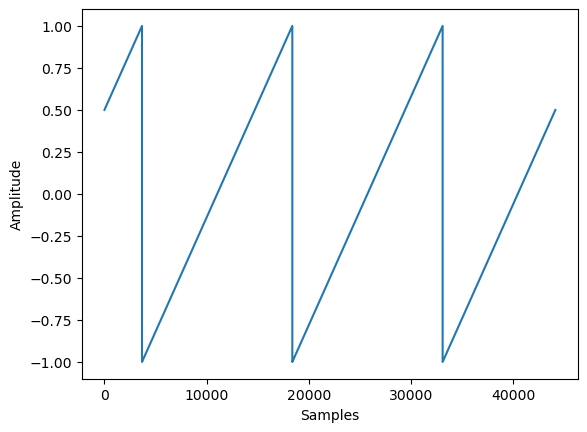

In [45]:
from synth.oscillators.sawtooth_oscillator import SawtoothOscillator

y = list(itertools.islice(SawtoothOscillator(freq=3), SAMPLE_RATE))
x = np.arange(SAMPLE_RATE)

plt.plot(x, y)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Triangle wave

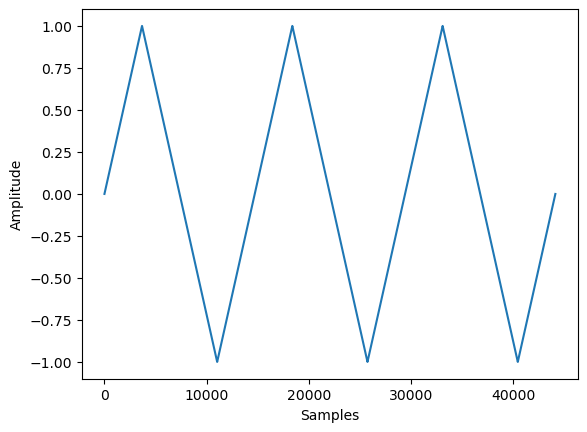

In [46]:
from synth.oscillators.triangle_oscillator import TriangleOscillator

y = list(itertools.islice(TriangleOscillator(freq=3), SAMPLE_RATE))
x = np.arange(SAMPLE_RATE)

plt.plot(x, y)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Harmonic Analysis

By computing the Fourier transform we can observe the waves in the frequency domain.
We can observe that the sine wave has no harmonics besides the fundamental frequency (which is set to 100 Hz for each wave). In contrast to the sine wave, the square and triangle waves have odd harmonic frequencies (odd multiples of the fundamental frequency) with the energy of the triangle wave decaying faster in the higher frequencies. The sawtooth wave has both odd and even harmonics.

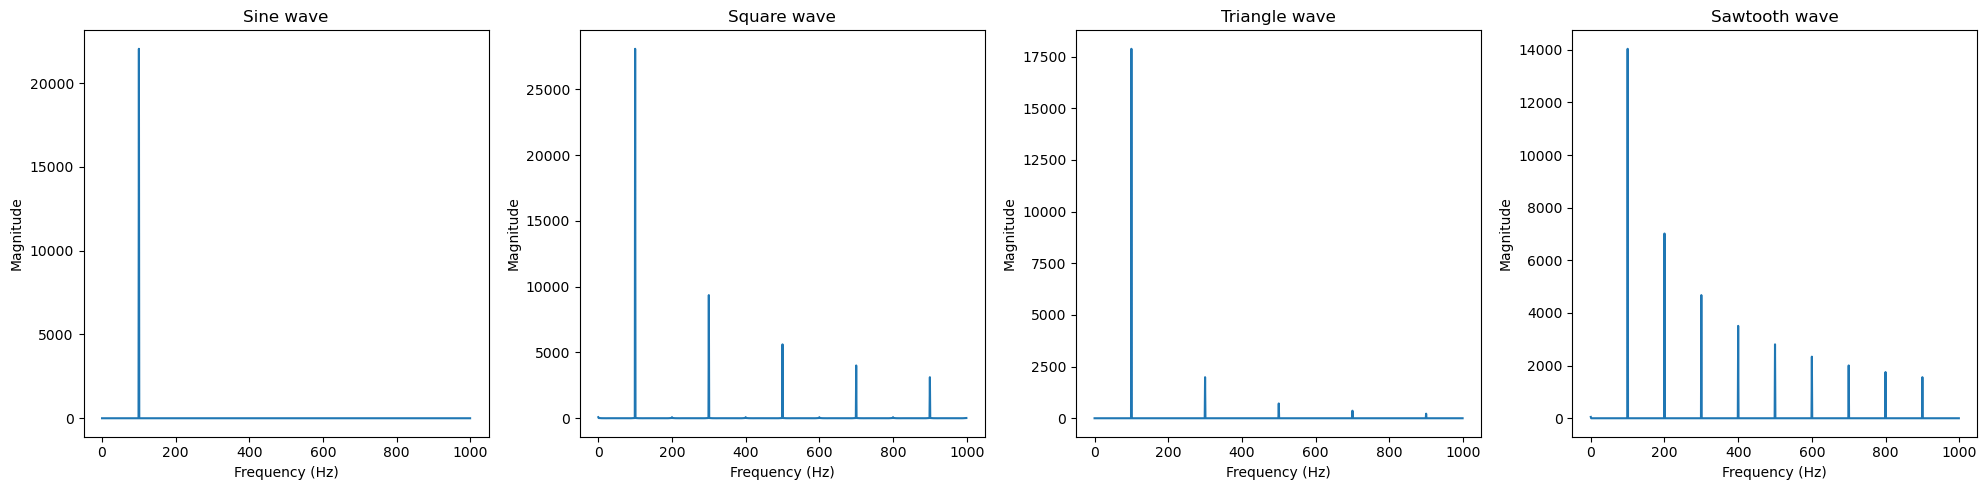

In [47]:
MAX_FREQ = 1_000 # Max frequency for plotting DFTs

# Get oscillators samples
n = np.arange(SAMPLE_RATE)
x_sine = list(itertools.islice(SineOscillator(freq=100), SAMPLE_RATE))
x_square = list(itertools.islice(SquareOscillator(freq=100), SAMPLE_RATE))
x_triangle = list(itertools.islice(TriangleOscillator(freq=100), SAMPLE_RATE))
x_saw = list(itertools.islice(SawtoothOscillator(freq=100), SAMPLE_RATE))

# Compute Fourier transform
freq = np.fft.fftfreq(SAMPLE_RATE, 1 / SAMPLE_RATE) # dw = 1 Hz
X_sine = np.fft.fft(x_sine, SAMPLE_RATE)
X_square = np.fft.fft(x_square, SAMPLE_RATE)
X_triangle = np.fft.fft(x_triangle, SAMPLE_RATE)
X_saw = np.fft.fft(x_saw, SAMPLE_RATE)

# Plots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_freq = freq[:MAX_FREQ]

# Sine wave
axs[0].plot(plot_freq, np.abs(X_sine)[:MAX_FREQ])
axs[0].set_title('Sine wave')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude')

# Square wave
axs[1].plot(plot_freq, np.abs(X_square)[:MAX_FREQ])
axs[1].set_title('Square wave')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')

# Square wave
axs[2].plot(plot_freq, np.abs(X_triangle)[:MAX_FREQ])
axs[2].set_title('Triangle wave')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Magnitude')

# Square wave
axs[3].plot(plot_freq, np.abs(X_saw)[:MAX_FREQ])
axs[3].set_title('Sawtooth wave')
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Magnitude')

# WAVs
samples_to_wav(x_sine, 'oscillators/sine.wav')
samples_to_wav(x_square, 'oscillators/square.wav')
samples_to_wav(x_triangle, 'oscillators/triangle.wav')
samples_to_wav(x_saw, 'oscillators/sawtooth.wav')

plt.tight_layout()
plt.show()

## Additive Synthesis

By summing waves at different frequencies (and eventually amplitude) we can create different and more complex harmonics. For example, here I'm using two sine waves and two triangle waves to produce an A minor chord.

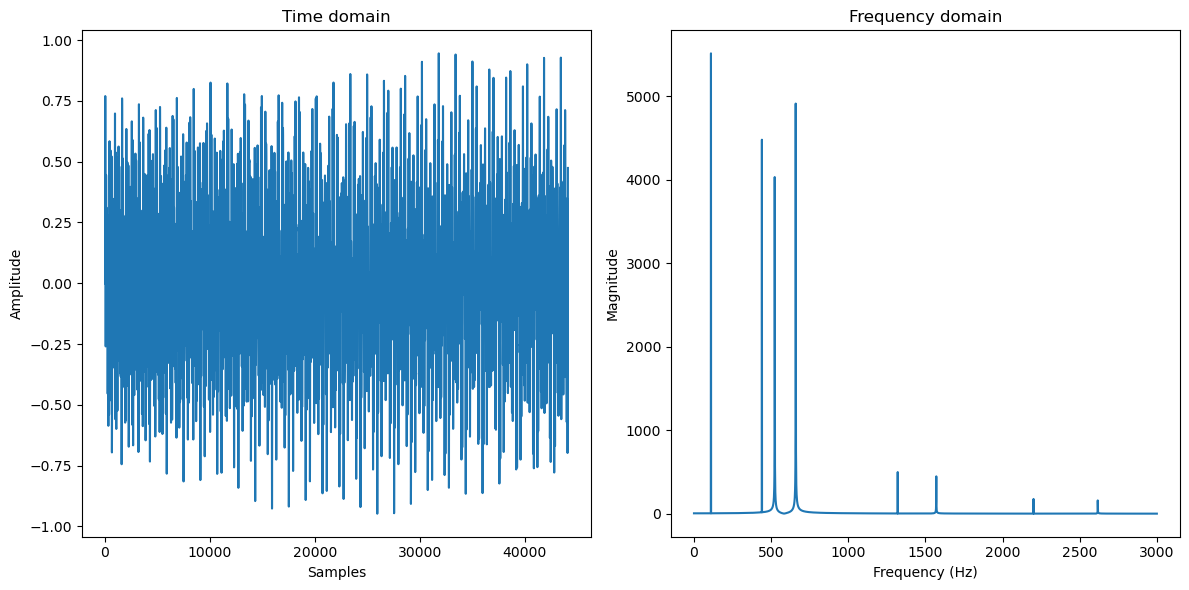

In [54]:
from synth.modulation.wave_adder import WaveAdder

# A minor chord
oscillators = (
    SineOscillator(freq=110),   # A2
    TriangleOscillator(freq=440),   # A4
    TriangleOscillator(freq=523.25), # C5
    SineOscillator(freq=659.26), # E5
)

# Create wave adder
wave_adder = iter(WaveAdder(*oscillators))

samples_to_wav([next(wave_adder) for _ in range(SAMPLE_RATE * 2)], 'oscillators/wave_adder.wav')

# Get 1 seconds samples
x = list(itertools.islice(wave_adder, SAMPLE_RATE))
n = np.arange(SAMPLE_RATE)

# Compute Fourier transform
X = np.fft.fft(x)
freq = np.fft.fftfreq(SAMPLE_RATE, d=1/SAMPLE_RATE)

# Plots
plt.figure(figsize=(12, 6))

# Time domain plot
plt.subplot(1, 2, 1)
plt.plot(n, x)
plt.title('Time domain')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Frequency domain plot
plt.subplot(1, 2, 2)
plt.plot(freq[:MAX_FREQ], np.abs(X[:MAX_FREQ]))
plt.title('Frequency domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

# Modulation

Modulation is the process of shaping sound over time. In this section I will show two modulators and explain how they can be used to shape sound generated from the previously shown oscillators, both in amplitude (Amplitude Modulation) and frequency (Frequency Modulation).

## ADSR Envelope

An ADSR Envelope has 4 stages (in this case, I will assume AM modulation):
- **Attack**: the time taken for a note to go from 0 to full volume. For example, for plucked and percussive instruments this time taken is instant, but say for something like a string (violin, cello, etc.) can be much slower.
- **Decay**: the time taken to reach the sustain level.
- **Sustain**: the level (of amplitude) at which the note is held. For example, the sustain of a piano will have decreasing amplitude over time, which is why the note will eventually die out.
- **Release**: the time taken for the note to die out after it's released.

The following plot will show how each part of the ADSR creates an envelope that shapes the waveform.

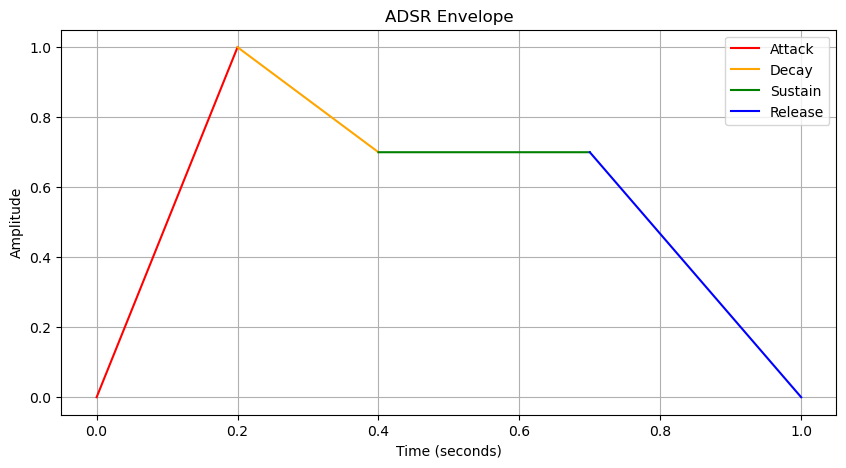

In [55]:
ATTACK_LENGTH = 0.2
DECAY_LENGTH = 0.2
RELEASE_LENGTH = 0.3
SUSTAIN_LEVEL = 0.7
SUSTAIN_LENGTH = 1 - (RELEASE_LENGTH + ATTACK_LENGTH + DECAY_LENGTH)

attack = np.linspace(0, 1, int(ATTACK_LENGTH * SAMPLE_RATE))
decay = np.linspace(1, SUSTAIN_LEVEL, int(DECAY_LENGTH * SAMPLE_RATE))
sustain = np.full(int(SUSTAIN_LENGTH * SAMPLE_RATE), SUSTAIN_LEVEL)
release = np.linspace(SUSTAIN_LEVEL, 0, int(RELEASE_LENGTH * SAMPLE_RATE))

# Combine all segments into a single envelope
adsr_envelope = np.concatenate([attack, decay, sustain, release])

# Generate segment indices for plotting
attack_x = np.arange(len(attack)) / SAMPLE_RATE
decay_x = np.arange(len(attack), len(attack) + len(decay)) / SAMPLE_RATE
sustain_x = np.arange(len(attack) + len(decay), len(attack) + len(decay) + len(sustain)) / SAMPLE_RATE
release_x = np.arange(len(attack) + len(decay) + len(sustain), len(adsr_envelope)) / SAMPLE_RATE

# Plot
plt.figure(figsize=(10, 5))
plt.plot(attack_x, attack, label="Attack", color="red")
plt.plot(decay_x, decay, label="Decay", color="orange")
plt.plot(sustain_x, sustain, label="Sustain", color="green")
plt.plot(release_x, release, label="Release", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("ADSR Envelope")
plt.legend()
plt.grid()
plt.show()

In the following examples I will use the ADSR envelope to modulate (both in amplitude and frequency) a 55 Hz square wave.
In the AM modulation plot you can see how the envelope is shaping the amplitude of the sound.
In the FM modulation plot you can see how the frequency will start slowly increasing following the attack stage, it will reach 55 Hz on the sustain stage and then it will decrease again during the release stage. By using the STFT I plotted the same FM wave on the spectrogram and it can be clearly seen that the ADSR shape is still present even in the frequency domain. The same shape can also be observed, with decreasing energy, for each odd harmonic of the 55 Hz square wave (165 Hz, 275 Hz, etc.).

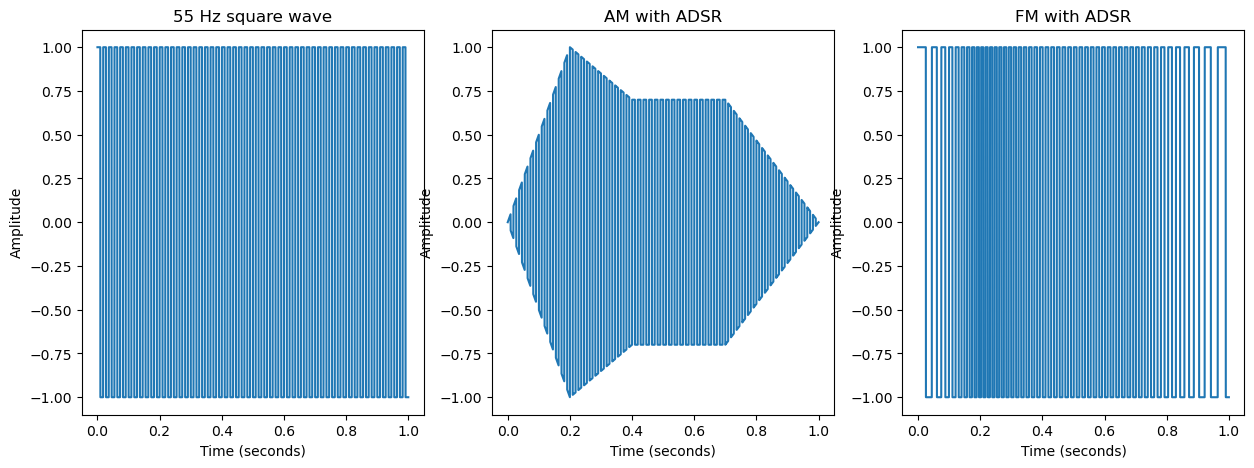

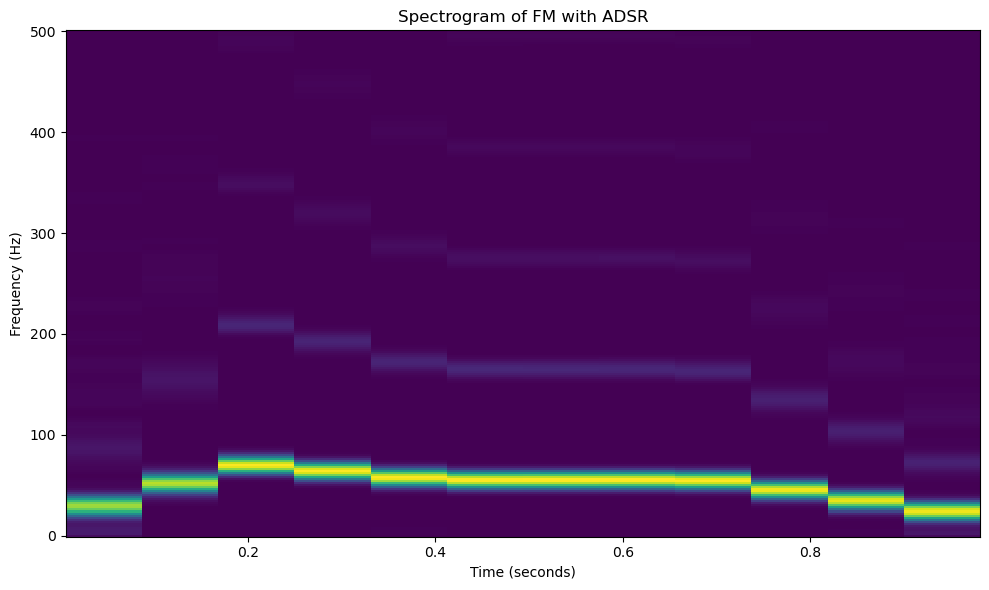

In [50]:
from synth.modulation.adsr_envelope import ADSREnvelope
from synth.modulation.modulated_oscillator import ModulatedOscillator

# Iterator utilities function used for plotting
def get_val(osc, count):
    return [next(osc) for i in range(count)]

def get_adsr(osc, a, d, s, r):
    ads_length = 1 - r
    ads_val = get_val(osc, round(ads_length * SAMPLE_RATE))
    osc.trigger_release()
    r_val = get_val(osc, round(r * SAMPLE_RATE))
    return np.concatenate([ads_val, r_val])

# Amplitude Modulation
def amp_mod(init_amp, env):
    return env * init_amp

# Frequency (and Phase) Modulation
def freq_mod(init_freq, env, mod_amt=1, sustain_level=0.7):
    # When env is at sustain stage it will play the initial frequency
    return init_freq + ((env - sustain_level) * init_freq * mod_amt)


x = np.arange(0, 1, step=1 / SAMPLE_RATE)

# 55Hz square wave with no modulation
osc = SquareOscillator(freq=55)
y_unmod = list(itertools.islice(osc, SAMPLE_RATE))

# Customizable ADSR envelope
adsr_envelope = ADSREnvelope(attack_duration=ATTACK_LENGTH, decay_duration=DECAY_LENGTH, sustain_level=SUSTAIN_LEVEL, release_duration=RELEASE_LENGTH)

# 55Hz square wave with Amplitude Modulation
am_mod_osc = ModulatedOscillator(osc, adsr_envelope, amp_mod=amp_mod)
am_mod_osc = iter(am_mod_osc)
y_am = get_adsr(am_mod_osc, adsr_envelope.attack_duration, adsr_envelope.decay_duration,
                adsr_envelope.sustain_level, adsr_envelope.release_duration)

# 55Hz square wave with Frequency Modulation
fm_mod_osc = ModulatedOscillator(osc, adsr_envelope, freq_mod=freq_mod)
fm_mod_osc = iter(fm_mod_osc)
y_fm = get_adsr(fm_mod_osc, adsr_envelope.attack_duration, adsr_envelope.decay_duration,
                adsr_envelope.sustain_level, adsr_envelope.release_duration)

# Plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Default
axs[0].plot(x, y_unmod)
axs[0].set_title('55 Hz square wave')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Amplitude')
axs[0].set_ylim(-1.10, 1.10)

# AM
axs[1].plot(x, y_am)
axs[1].set_title('AM with ADSR')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Amplitude')
axs[1].set_ylim(-1.10, 1.10)

# FM
axs[2].plot(x, y_fm)
axs[2].set_title('FM with ADSR')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Amplitude')
axs[2].set_ylim(-1.10, 1.10)

# Spectrogram for FM using signal.spectrogram and pcolormesh
plt.figure(figsize=(10, 6))

# Compute spectrogram
# nfft = DFT resolution
# nperseg = window length
f, t, Sxx = spectrogram(y_fm, fs=SAMPLE_RATE, nperseg=4096, nfft=SAMPLE_RATE//2, window='hamming')

max_freq = 500
f_idx = f <= max_freq  # Find indices where frequency is below the max_freq

# Spectrogram plot
plt.pcolormesh(t, f[f_idx], Sxx[f_idx, :]) 
plt.title('Spectrogram of FM with ADSR')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

samples_to_wav(y_unmod, 'modulation/default.wav')
samples_to_wav(y_am, 'modulation/AM_adsr.wav')
samples_to_wav(y_fm, 'modulation/FM_adsr.wav')

## LFO (Low Frequency Oscillator)

The same concept explained for the ADSR modulation can be applied using an oscillator as a modulator. An LFO is a low frequency oscillator that can be used to control the amplitude or frequency of the sound. In this example I will be using a 3 Hz sine wave to modulate the frequency of a 220 Hz sine wave. Just as before, in the spectrogram the shape of the LFO can be observed. In this case there will be just one copy around the fundamental frequency of the sine wave.

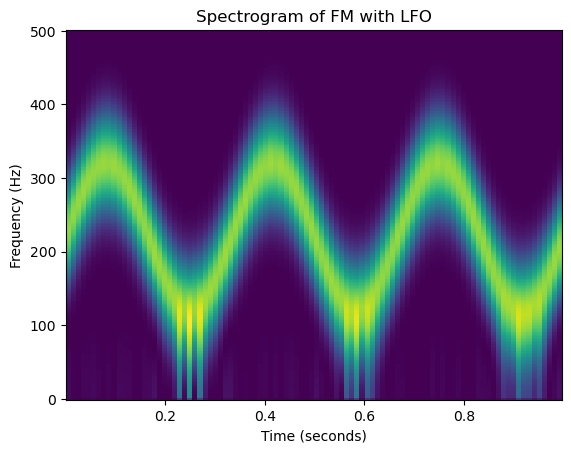

In [51]:
def freq_mod(init_freq, mod, amt=100):
    return init_freq + mod * amt

lfo = SineOscillator(freq=3) # 3 Hz LFO

# Oscillator
oscillator = ModulatedOscillator(SineOscillator(220), lfo, freq_mod=freq_mod)
oscillator = iter(oscillator)
x = get_val(oscillator, SAMPLE_RATE)
n = np.arange(0, 1, step=1/SAMPLE_RATE)

# Compute spectrogram
# nfft = DFT resolution
# nperseg = window length
f, t, Sxx = spectrogram(np.array(x), fs=SAMPLE_RATE, nperseg=512, nfft=SAMPLE_RATE//2, window='hamming')

max_freq = 500
f_idx = f <= max_freq  # Find indices where frequency is below the max_freq

# Spectrogram plot
plt.pcolormesh(t, f[f_idx], Sxx[f_idx, :]) 
plt.title('Spectrogram of FM with LFO')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

# WAV
samples_to_wav(x, 'modulation/lfo.wav')

# Effects

## Low-Pass and High-pass Filters

In this example I used the Butterworth filter, which is a filter designed to have a flat frequency response in the passband, to reduce frequencies greater (low-pass) or smaller (high-pass) than a set cutoff frequency. Increasing the order of the filter will shorten the transition band.
Since I used this as an experiment before applying it in the real-time synth, I applied the filter to two adjacent chunks of the wave, each of length *NUM_SAMPLES*, to ensure that there were no sudden jumps or discontinuities between the chunks when transitioning from one to the next. I also plotted the pole-zero plot of the filter, from which it can be observed that it has *FILTER_ORDER* poles and zeros, confirming the causality of the filter. Additionally, all the poles are inside the unit circle in the Z-plane implying the filter's stability as well.

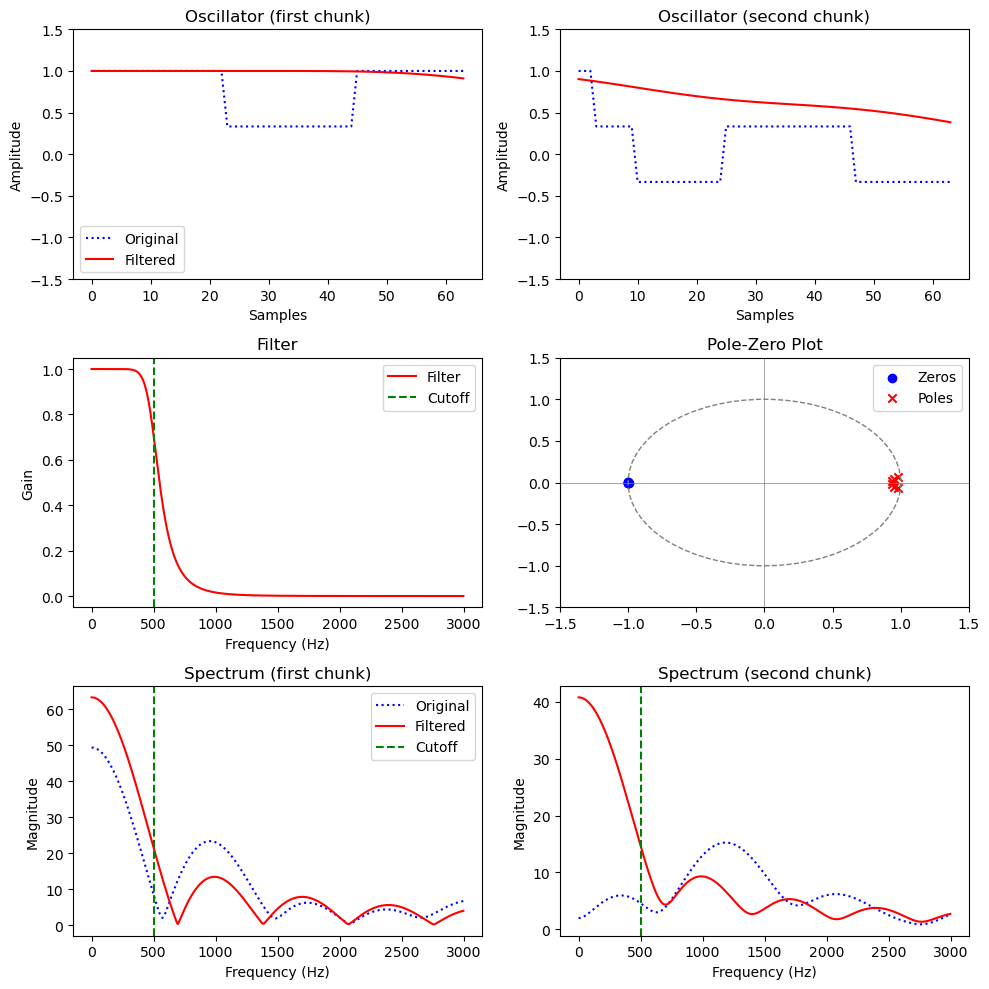

In [52]:
NUM_SAMPLES = 64
ZERO_PADDING_LENGTH = SAMPLE_RATE
MAX_FREQ = 3000 #SAMPLE_RATE / 2 # Max frequency for plots
CUTOFF = 500
FILTER_TYPE = 'low' #'high'
FILTER_ORDER = 6
 
def butter_lowpass(cutoff, fs, order=1):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)
 
def butter_lowpass_filter(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order)
    return lfilter(b, a, data)
 
def get_samples(oscillator):
    samples = []
    for _ in range(NUM_SAMPLES):
        samples.append(next(oscillator))
    return samples

# Test oscillator
oscillator = iter(
    WaveAdder(
        *(SquareOscillator(freq=100), SquareOscillator(freq=300), SquareOscillator(freq=1000))
    )
)
# Set up plot grid
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Get samples
samples1 = get_samples(oscillator) # First chunk of samples
samples2 = get_samples(oscillator) # Second chunk of samples
n = np.arange(NUM_SAMPLES)

# Filter creation
b, a = butter(N=FILTER_ORDER, Wn=CUTOFF, fs=SAMPLE_RATE, btype=FILTER_TYPE, analog=False) # Get filter coefficients
zi = lfilter_zi(b, a) # Get initial state
w, h = freqz(b, a, fs=SAMPLE_RATE, worN=SAMPLE_RATE // 2) # Get frequency response
z, p, k = tf2zpk(b, a) # Get poles and zeros

# Filtering samples
samples1f, zi = lfilter(b, a, samples1, zi=zi)
samples2f, zi = lfilter(b, a, samples2, zi=zi)

# Original and filtered oscillators plot
axs[0][0].plot(n, samples1, label='Original', linestyle=':', color='blue')
axs[0][0].plot(n, samples1f, label='Filtered', color='red')
axs[0][0].set_title('Oscillator (first chunk)')
axs[0][0].set_xlabel('Samples')
axs[0][0].set_ylabel('Amplitude')
axs[0][0].set_ylim([-1.5, 1.5])
axs[0][0].legend()

axs[0][1].plot(n, samples2, label='Original', linestyle=':', color='blue')
axs[0][1].plot(n, samples2f, label='Filtered', color='red')
axs[0][1].set_title('Oscillator (second chunk)')
axs[0][1].set_xlabel('Samples')
axs[0][1].set_ylabel('Amplitude')
axs[0][1].set_ylim([-1.5, 1.5])

# Zero-pad the samples to increase plot precision
x1 = np.zeros(ZERO_PADDING_LENGTH)
x1[:NUM_SAMPLES] = samples1
x2 = np.zeros(ZERO_PADDING_LENGTH)
x2[:NUM_SAMPLES] = samples2
xf1 = np.zeros(ZERO_PADDING_LENGTH)
xf1[:NUM_SAMPLES] = samples1f
xf2 = np.zeros(ZERO_PADDING_LENGTH)
xf2[:NUM_SAMPLES] = samples2f

# Compute DFTs
X1 = np.fft.fft(x1, ZERO_PADDING_LENGTH)
X2 = np.fft.fft(x2, ZERO_PADDING_LENGTH)
Xf1 = np.fft.fft(xf1, ZERO_PADDING_LENGTH)
Xf2 = np.fft.fft(xf2, ZERO_PADDING_LENGTH)

# Sampling the DTFT every (SAMPLE_RATE / ZERO_PADDING_LENGTH) Hz
freq = np.fft.fftfreq(ZERO_PADDING_LENGTH, 1 / SAMPLE_RATE)

# Zoom in the DFT
freq = freq[:ZERO_PADDING_LENGTH // 2] # Positive frequencies
last_index = np.max(np.where(freq < MAX_FREQ)) # Last index closer to MAX_FREQ
#last_index = ZERO_PADDING_LENGTH // 2

# Filter frequency response plot
axs[1][0].plot(w[:last_index], np.abs(h)[:last_index], color='red', label='Filter')
axs[1][0].axvline(CUTOFF, color='green', linestyle='--', label='Cutoff')
axs[1][0].set_title('Filter')
axs[1][0].set_xlabel('Frequency (Hz)')
axs[1][0].set_ylabel('Gain')
axs[1][0].legend()

# Poles and zero plot
axs[1][1].scatter(np.real(z), np.imag(z), marker='o', label='Zeros', color='blue')
axs[1][1].scatter(np.real(p), np.imag(p), marker='x', label='Poles', color='red')
axs[1][1].axhline(0, color='gray', linewidth=0.5)
axs[1][1].axvline(0, color='gray', linewidth=0.5)
axs[1][1].add_artist(plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='dashed'))  # Unit circle
axs[1][1].set_xlim([-1.5, 1.5])
axs[1][1].set_ylim([-1.5, 1.5])
axs[1][1].set_title('Pole-Zero Plot')
axs[1][1].legend()

# Oscillators spectra
axs[2][0].plot(freq[:last_index], np.abs(X1)[:last_index], label='Original', linestyle=':', color='blue')
axs[2][0].plot(freq[:last_index], np.abs(Xf1)[:last_index], label='Filtered', color='red')
axs[2][0].axvline(CUTOFF, color='green', linestyle='--', label='Cutoff')
axs[2][0].set_title('Spectrum (first chunk)')
axs[2][0].set_xlabel('Frequency (Hz)')
axs[2][0].set_ylabel('Magnitude')
axs[2][0].legend()
axs[2][1].plot(freq[:last_index], np.abs(X2)[:last_index], label='Original', linestyle=':', color='blue')
axs[2][1].plot(freq[:last_index], np.abs(Xf2)[:last_index], label='Filtered', color='red')
axs[2][1].axvline(CUTOFF, color='green', linestyle='--', label='Cutoff')
axs[2][1].set_title('Spectrum (second chunk)')
axs[2][1].set_xlabel('Frequency (Hz)')
axs[2][1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [56]:
TOTAL_TIME = 2 # in seconds
NUM_SAMPLES = 256 # Size of a chunk
CUTOFF = 300

# Bmaj7
oscillator = iter(WaveAdder(
        *(
          SawtoothOscillator(freq=246.942), # B3
          SawtoothOscillator(freq=311.127), # D#4
          SawtoothOscillator(freq=369.994), # F#4
          SawtoothOscillator(freq=466.164) # A#4
        )
    )
)

# Total number of samples to generate
total_samples = int(SAMPLE_RATE * TOTAL_TIME)
all_samples = []
all_filtered_samples = []

# Filter coefficients
b, a = butter(N=FILTER_ORDER, Wn=CUTOFF, fs=SAMPLE_RATE, btype=FILTER_TYPE, analog=False)

# Get initial filter state
zi = lfilter_zi(b, a)  # Initial state of the filter

# Process audio in blocks
for start in range(0, total_samples, NUM_SAMPLES):
    # Generate next block of samples
    samples = get_samples(oscillator)
    all_samples.extend(samples) # Store unfiltered signal
    
    # Apply filter
    filtered_samples, zi = lfilter(b, a, samples, zi=zi)
    
    # Store filtered
    all_filtered_samples.extend(filtered_samples)

# Save to WAV files
samples_to_wav(all_samples, 'filters/oscillator.wav')
samples_to_wav(all_filtered_samples, 'filters/filtered_oscillator.wav')